<a href="https://colab.research.google.com/github/gautamrajur/gpu_profiler/blob/main/gpu_profiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Checking GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️  GPU not detected. Make sure Runtime -> Change runtime type -> GPU is selected")

!pip install plotly seaborn streamlit -q

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.7 MB/s eta 0:00:00


In [ ]:
import os
import json
import time
import logging
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.profiler import profile, record_function, ProfilerActivity, schedule
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import HTML, display

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure logging for Colab
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

print("All libraries imported successfully!")


✅ All libraries imported successfully!


In [ ]:
class ColabGPUProfiler:
    """optimized GPU profiler for deep learning training analysis"""

    def __init__(self, output_dir: str = "/content/profiling_results"):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        # Profiling data storage
        self.metrics = defaultdict(list)
        self.kernel_stats = []
        self.memory_timeline = []
        self.batch_size_history = []
        self.layer_times = {}
        self.layer_memory = {}

        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Display GPU info
        if torch.cuda.is_available():
            print(f"🚀 GPU Profiler initialized on: {torch.cuda.get_device_name()}")
            print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        else:
            print("⚠️  Running on CPU - limited profiling capabilities")

    def setup_model(self, model_name: str = "resnet18", num_classes: int = 10) -> nn.Module:
        """Setup model for profiling"""
        print(f"🏗️  Setting up {model_name} model...")

        if model_name == "resnet18":
            model = models.resnet18(pretrained=False, num_classes=num_classes)
        elif model_name == "resnet50":
            model = models.resnet50(pretrained=False, num_classes=num_classes)
        elif model_name == "simple_cnn":
            model = self._create_simple_cnn(num_classes)
        elif model_name == "transformer":
            model = self._create_simple_transformer(num_classes)
        else:
            raise ValueError(f"Unknown model: {model_name}")

        model = model.to(self.device)
        print(f"✅ Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")
        return model

    def _create_simple_cnn(self, num_classes: int) -> nn.Module:
        """Create a simple CNN for profiling"""
        return nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def _create_simple_transformer(self, num_classes: int) -> nn.Module:
        """Create a simple transformer for profiling"""
        class SimpleTransformer(nn.Module):
            def __init__(self, input_dim=3072, hidden_dim=512, num_heads=8, num_layers=4, num_classes=10):
                super().__init__()
                self.input_proj = nn.Linear(input_dim, hidden_dim)
                self.pos_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
                encoder_layer = nn.TransformerEncoderLayer(
                    d_model=hidden_dim, nhead=num_heads, batch_first=True,
                    dim_feedforward=hidden_dim * 2, dropout=0.1
                )
                self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
                self.classifier = nn.Linear(hidden_dim, num_classes)

            def forward(self, x):
                x = x.view(x.size(0), -1)  # Flatten
                x = self.input_proj(x).unsqueeze(1)
                x = x + self.pos_embedding
                x = self.transformer(x)
                x = x.squeeze(1)
                return self.classifier(x)

        return SimpleTransformer(num_classes=num_classes)

    def create_dataloader(self, dataset_name: str = "cifar10", batch_size: int = 64) -> Tuple[DataLoader, DataLoader]:
        """Create optimized dataloaders for Colab"""
        print(f"📁 Loading {dataset_name} dataset...")

        if dataset_name == "cifar10":
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

            # Download to /content for Colab
            train_dataset = CIFAR10(root='/content/data', train=True, download=True, transform=transform)
            val_dataset = CIFAR10(root='/content/data', train=False, download=True, transform=transform)

            # Using subset for faster profiling in Colab
            train_indices = torch.randperm(len(train_dataset))[:5000]  # 5k samples
            val_indices = torch.randperm(len(val_dataset))[:1000]     # 1k samples

            train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
            val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

        else: #Failsafe
            # Synthetic data for quick testing
            train_data = torch.randn(2000, 3, 32, 32)
            train_labels = torch.randint(0, 10, (2000,))
            val_data = torch.randn(400, 3, 32, 32)
            val_labels = torch.randint(0, 10, (400,))

            train_dataset = TensorDataset(train_data, train_labels)
            val_dataset = TensorDataset(val_data, val_labels)

        # Optimized for Colab GPU
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True,
            num_workers=2, pin_memory=True, persistent_workers=True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False,
            num_workers=2, pin_memory=True, persistent_workers=True
        )

        print(f"✅ Dataset loaded: {len(train_dataset)} train, {len(val_dataset)} val samples")
        return train_loader, val_loader

    def register_hooks(self, model: nn.Module):
        """Register profiling hooks"""
        print("🔗 Registering profiling hooks...")

        def forward_hook(name):
            def hook(module, input, output):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                    mem_allocated = torch.cuda.memory_allocated() / 1e6  # MB
                    self.layer_memory[f"{name}_forward"] = mem_allocated
            return hook

        def backward_hook(name):
            def hook(module, grad_input, grad_output):
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                    mem_allocated = torch.cuda.memory_allocated() / 1e6  # MB
                    self.layer_memory[f"{name}_backward"] = mem_allocated
            return hook

        # Register hooks for major modules
        hook_count = 0
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear, nn.TransformerEncoderLayer)):
                module.register_forward_hook(forward_hook(name))
                module.register_full_backward_hook(backward_hook(name))
                hook_count += 1

        print(f"✅ Registered {hook_count} profiling hooks")

    def dynamic_batch_size_optimization(self, model: nn.Module, train_loader: DataLoader,
                                      criterion: nn.Module, optimizer: optim.Optimizer) -> int:
        """Find optimal batch size for Colab GPU"""
        print("🔧 Optimizing batch size for GPU...")

        min_batch_size = 16
        max_batch_size = 256  # Conservative for Colab
        optimal_batch_size = min_batch_size

        test_results = []

        for batch_size in [16, 32, 64, 128, 256]:
            try:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    torch.cuda.reset_peak_memory_stats()

                # Test batch
                test_data = torch.randn(batch_size, 3, 32, 32).to(self.device)
                test_targets = torch.randint(0, 10, (batch_size,)).to(self.device)

                start_time = time.time()

                optimizer.zero_grad()
                outputs = model(test_data)
                loss = criterion(outputs, test_targets)
                loss.backward()
                optimizer.step()

                if torch.cuda.is_available():
                    torch.cuda.synchronize()

                end_time = time.time()
                batch_time = end_time - start_time
                throughput = batch_size / batch_time

                memory_used = 0
                memory_util = 0
                if torch.cuda.is_available():
                    memory_used = torch.cuda.max_memory_allocated() / 1e9  # GB
                    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
                    memory_util = memory_used / total_memory

                test_results.append({
                    'batch_size': batch_size,
                    'throughput': throughput,
                    'memory_used': memory_used,
                    'memory_util': memory_util,
                    'batch_time': batch_time
                })

                # Experimenting with batch sizes
                if memory_util < 0.8:  # 80% threshold for Colab
                    optimal_batch_size = batch_size

                print(f"  Batch {batch_size:3d}: {throughput:6.1f} samples/sec, {memory_util*100:4.1f}% GPU memory")

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"  Batch {batch_size:3d}: OOM - too large")
                    break
                else:
                    raise e

        self.batch_size_history = test_results
        print(f"✅ Optimal batch size: {optimal_batch_size}")
        return optimal_batch_size

    def profile_training(self, model: nn.Module, train_loader: DataLoader,
                        val_loader: DataLoader, epochs: int = 3,
                        optimize_batch_size: bool = True) -> Dict[str, Any]:
        """Main profiling loop optimized for Colab"""

        print("🏃 Starting GPU profiling...")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        # Registering hooks
        self.register_hooks(model)

        # Optimized batch size
        if optimize_batch_size and torch.cuda.is_available():
            optimal_batch_size = self.dynamic_batch_size_optimization(model, train_loader, criterion, optimizer)
            # Recreating dataloader with optimal batch size
            dataset = train_loader.dataset
            train_loader = DataLoader(dataset, batch_size=optimal_batch_size, shuffle=True,
                                    num_workers=2, pin_memory=True, persistent_workers=True)

        # Profiler setup
        activities = [ProfilerActivity.CPU]
        if torch.cuda.is_available():
            activities.append(ProfilerActivity.CUDA)

        # profiler scheduler
        schedule_fn = schedule(wait=1, warmup=1, active=2, repeat=1)

        start_training = time.time()

        with profile(
            activities=activities,
            schedule=schedule_fn,
            on_trace_ready=self._trace_handler,
            record_shapes=True,
            profile_memory=True,
            with_stack=True
        ) as prof:

            for epoch in range(epochs):
                print(f"\n📊 Epoch {epoch+1}/{epochs}")

                # Training phase
                model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0

                epoch_start = time.time()

                for batch_idx, (data, targets) in enumerate(train_loader):
                    #The magic begins. Very Important.
                    # Data transfer with profiling
                    with record_function("data_transfer"):
                        data = data.to(self.device, non_blocking=True)
                        targets = targets.to(self.device, non_blocking=True)

                    # Memory tracking
                    if torch.cuda.is_available():
                        torch.cuda.synchronize()
                        batch_start_memory = torch.cuda.memory_allocated()

                    batch_start_time = time.time()

                    # Forward pass
                    with record_function("forward_pass"):
                        optimizer.zero_grad()
                        outputs = model(data)
                        loss = criterion(outputs, targets)

                    # Backward pass
                    with record_function("backward_pass"):
                        loss.backward()

                    # Optimizer step
                    with record_function("optimizer_step"):
                        optimizer.step()

                    if torch.cuda.is_available():
                        torch.cuda.synchronize()

                    batch_end_time = time.time()
                    batch_time = batch_end_time - batch_start_time

                    # Track metrics
                    train_loss += loss.item()
                    _, predicted = outputs.max(1)
                    train_total += targets.size(0)
                    train_correct += predicted.eq(targets).sum().item()

                    # Memory tracking
                    if torch.cuda.is_available():
                        current_memory = torch.cuda.memory_allocated()
                        memory_delta = current_memory - batch_start_memory

                        self.memory_timeline.append({
                            'epoch': epoch,
                            'batch': batch_idx,
                            'memory_allocated': current_memory / 1e6,  # MB
                            'memory_delta': memory_delta / 1e6,  # MB
                            'batch_time': batch_time,
                            'throughput': len(data) / batch_time
                        })

                    # Progress update
                    if batch_idx % 10 == 0:
                        print(f"  Batch {batch_idx:3d}: Loss {loss.item():.4f}, "
                              f"{len(data)/batch_time:6.1f} samples/sec")

                    prof.step()

                    # Limit batches for Colab (prevent timeout)
                    if batch_idx >= 20:
                        break

                epoch_end = time.time()
                epoch_time = epoch_end - epoch_start

                train_acc = 100. * train_correct / train_total if train_total > 0 else 0
                avg_train_loss = train_loss / min(len(train_loader), 20)

                # Quick validation
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0

                with torch.no_grad():
                    for batch_idx, (data, targets) in enumerate(val_loader):
                        data, targets = data.to(self.device), targets.to(self.device)
                        outputs = model(data)
                        loss = criterion(outputs, targets)

                        val_loss += loss.item()
                        _, predicted = outputs.max(1)
                        val_total += targets.size(0)
                        val_correct += predicted.eq(targets).sum().item()

                        if batch_idx >= 5:  # Quick validation
                            break

                val_acc = 100. * val_correct / val_total if val_total > 0 else 0
                avg_val_loss = val_loss / min(len(val_loader), 5)

                # Store metrics
                self.metrics['epoch'].append(epoch)
                self.metrics['train_loss'].append(avg_train_loss)
                self.metrics['train_acc'].append(train_acc)
                self.metrics['val_loss'].append(avg_val_loss)
                self.metrics['val_acc'].append(val_acc)
                self.metrics['epoch_time'].append(epoch_time)

                print(f"  📈 Train: {avg_train_loss:.4f} loss, {train_acc:.1f}% acc")
                print(f"  📊 Val:   {avg_val_loss:.4f} loss, {val_acc:.1f}% acc")
                print(f"  ⏱️  Time: {epoch_time:.1f}s")

        total_time = time.time() - start_training
        print(f"\n✅ Profiling completed in {total_time:.1f}s")

        return self._extract_profiler_stats(prof)

    def _trace_handler(self, prof):
        """Handle profiler traces for Colab"""
        timestamp = datetime.now().strftime('%H%M%S')
        trace_path = self.output_dir / f"trace_{timestamp}.json"
        prof.export_chrome_trace(str(trace_path))
        print(f"📁 Trace saved: {trace_path}")

    def _extract_profiler_stats(self, prof) -> Dict[str, Any]:
        """Extract profiler statistics"""
        stats = {}

        # Get top CPU events
        cpu_events = prof.key_averages().table(sort_by="cpu_time_total", row_limit=10)
        stats['cpu_events'] = cpu_events

        if torch.cuda.is_available():
            cuda_events = prof.key_averages().table(sort_by="cuda_time_total", row_limit=10)
            stats['cuda_events'] = cuda_events

            memory_events = prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10)
            stats['memory_events'] = memory_events

        return stats

    def generate_colab_visualizations(self):
        """Generate visualizations optimized for Colab display"""
        print("📊 Generating visualizations...")

        # Create comprehensive dashboard
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Training Progress',
                'GPU Memory Usage',
                'Batch Size Optimization',
                'Training Throughput'
            ),
            specs=[[{"secondary_y": True}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )

        # Training progress
        if self.metrics.get('epoch'):
            epochs = self.metrics['epoch']

            # Loss curves
            fig.add_trace(
                go.Scatter(x=epochs, y=self.metrics['train_loss'],
                          name='Train Loss', line=dict(color='blue', width=3)),
                row=1, col=1
            )
            fig.add_trace(
                go.Scatter(x=epochs, y=self.metrics['val_loss'],
                          name='Val Loss', line=dict(color='red', width=3)),
                row=1, col=1
            )

            # Accuracy on secondary y-axis
            fig.add_trace(
                go.Scatter(x=epochs, y=self.metrics['train_acc'],
                          name='Train Acc (%)', line=dict(color='green', width=2, dash='dash'),
                          yaxis='y2'),
                row=1, col=1, secondary_y=True
            )

        # Memory usage
        if self.memory_timeline:
            memory_df = pd.DataFrame(self.memory_timeline)
            fig.add_trace(
                go.Scatter(y=memory_df['memory_allocated'],
                          name='GPU Memory (MB)',
                          line=dict(color='purple', width=2),
                          fill='tonexty'),
                row=1, col=2
            )

        # Batch size optimization
        if self.batch_size_history:
            batch_df = pd.DataFrame(self.batch_size_history)
            fig.add_trace(
                go.Scatter(x=batch_df['batch_size'], y=batch_df['throughput'],
                          mode='markers+lines', name='Throughput (samples/sec)',
                          marker=dict(size=10, color=batch_df['memory_util'],
                                    colorscale='Viridis', showscale=True,
                                    colorbar=dict(title="Memory %")),
                          line=dict(width=3)),
                row=2, col=1
            )

        # Throughput timeline
        if self.memory_timeline:
            fig.add_trace(
                go.Scatter(y=memory_df['throughput'],
                          name='Throughput',
                          line=dict(color='orange', width=2)),
                row=2, col=2
            )

        # Update layout
        fig.update_layout(
            height=800,
            title_text="🚀 GPU Training Profiler Dashboard",
            title_x=0.5,
            showlegend=True,
            template="plotly_white"
        )

        # Update axes labels
        fig.update_xaxes(title_text="Epoch", row=1, col=1)
        fig.update_xaxes(title_text="Batch Size", row=2, col=1)
        fig.update_yaxes(title_text="Loss", row=1, col=1)
        fig.update_yaxes(title_text="Memory (MB)", row=1, col=2)
        fig.update_yaxes(title_text="Throughput (samples/sec)", row=2, col=1)
        fig.update_yaxes(title_text="Throughput", row=2, col=2)

        # Save and display
        fig.write_html(self.output_dir / "colab_dashboard.html")
        fig.show()

        # Additional memory analysis plot
        if self.memory_timeline:
            self._create_memory_analysis()

        # Performance summary
        self._create_performance_summary()

    def _create_memory_analysis(self):
        """Create detailed memory analysis"""
        memory_df = pd.DataFrame(self.memory_timeline)

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('GPU Memory Analysis', fontsize=16)

        # Memory over time
        axes[0,0].plot(memory_df['memory_allocated'], color='purple', linewidth=2)
        axes[0,0].set_title('GPU Memory Usage Over Time')
        axes[0,0].set_ylabel('Memory (MB)')
        axes[0,0].grid(True, alpha=0.3)

        # Memory distribution
        axes[0,1].hist(memory_df['memory_allocated'], bins=20, color='skyblue', alpha=0.7)
        axes[0,1].set_title('Memory Usage Distribution')
        axes[0,1].set_xlabel('Memory (MB)')
        axes[0,1].set_ylabel('Frequency')

        # Throughput vs Memory
        scatter = axes[1,0].scatter(memory_df['memory_allocated'], memory_df['throughput'],
                                  c=memory_df['batch_time'], cmap='viridis', alpha=0.6)
        axes[1,0].set_title('Throughput vs Memory Usage')
        axes[1,0].set_xlabel('Memory (MB)')
        axes[1,0].set_ylabel('Throughput (samples/sec)')
        plt.colorbar(scatter, ax=axes[1,0], label='Batch Time (s)')

        # Batch time distribution
        axes[1,1].hist(memory_df['batch_time'], bins=20, color='lightcoral', alpha=0.7)
        axes[1,1].set_title('Batch Time Distribution')
        axes[1,1].set_xlabel('Batch Time (s)')
        axes[1,1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.savefig(self.output_dir / 'memory_analysis.png', dpi=150, bbox_inches='tight')
        plt.show()

    def _create_performance_summary(self):
        """Create performance summary table"""
        if not self.memory_timeline:
            return

        memory_df = pd.DataFrame(self.memory_timeline)

        summary = {
            'Metric': [
                'Average Throughput (samples/sec)',
                'Peak GPU Memory (MB)',
                'Average GPU Memory (MB)',
                'Average Batch Time (ms)',
                'Memory Efficiency (%)',
                'Total Samples Processed'
            ],
            'Value': [
                f"{memory_df['throughput'].mean():.1f}",
                f"{memory_df['memory_allocated'].max():.1f}",
                f"{memory_df['memory_allocated'].mean():.1f}",
                f"{memory_df['batch_time'].mean() * 1000:.1f}",
                f"{(memory_df['memory_allocated'].mean() / memory_df['memory_allocated'].max() * 100):.1f}",
                f"{len(memory_df) * memory_df.iloc[0]['throughput'] * memory_df.iloc[0]['batch_time']:.0f}"
            ]
        }

        summary_df = pd.DataFrame(summary)

        print("\n" + "="*50)
        print("PERFORMANCE SUMMARY")
        print("="*50)
        for _, row in summary_df.iterrows():
            print(f"{row['Metric']:<35}: {row['Value']}")
        print("="*50)

    def save_results(self):
        """Save results for Colab"""
        print(" Saving results...")

        results = {
            'profiling_metadata': {
                'timestamp': datetime.now().isoformat(),
                'device': str(self.device),
                'cuda_available': torch.cuda.is_available(),
            },
            'training_metrics': dict(self.metrics),
            'memory_timeline': self.memory_timeline,
            'batch_size_optimization': self.batch_size_history,
            'layer_memory_usage': self.layer_memory
        }

        if torch.cuda.is_available():
            results['profiling_metadata'].update({
                'gpu_name': torch.cuda.get_device_name(),
                'gpu_memory_total_gb': torch.cuda.get_device_properties(0).total_memory / 1e9,
                'gpu_compute_capability': f"{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}"
            })

        # comprehensive results
        with open(self.output_dir / "profiling_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)

        # Individual CSV files for easy analysis
        if self.metrics.get('epoch'):
            pd.DataFrame(self.metrics).to_csv(self.output_dir / "training_metrics.csv", index=False)

        if self.memory_timeline:
            pd.DataFrame(self.memory_timeline).to_csv(self.output_dir / "memory_timeline.csv", index=False)

        if self.batch_size_history:
            pd.DataFrame(self.batch_size_history).to_csv(self.output_dir / "batch_optimization.csv", index=False)

        print(f"✅ Results saved to: {self.output_dir}")

        # download links for Colab
        print("\n Download your results:")
        print(f"   - Profiling Results: /content/profiling_results/profiling_results.json")
        print(f"   - Dashboard: /content/profiling_results/colab_dashboard.html")
        print(f"   - Memory Analysis: /content/profiling_results/memory_analysis.png")

In [ ]:

def run_quick_profile(model_name="resnet18", dataset="cifar10", epochs=3, batch_size=64):
    """Quick profiling run optimized for Colab"""

    print("🚀 Starting GPU-Aware Deep Learning Profiler")
    print("="*60)

    # Initialize profiler
    profiler = ColabGPUProfiler()

    # Setup model
    model = profiler.setup_model(model_name)

    # Create data loaders
    train_loader, val_loader = profiler.create_dataloader(dataset, batch_size)

    # Run profiling
    profiling_stats = profiler.profile_training(
        model, train_loader, val_loader,
        epochs=epochs, optimize_batch_size=True
    )

    # Print key profiling stats
    print("\n🔍 KEY PROFILING STATISTICS")
    print("="*60)
    if torch.cuda.is_available():
        print(profiling_stats.get('cuda_events', 'No CUDA events captured'))
        print("\n" + profiling_stats.get('memory_events', 'No memory events captured'))
    else:
        print(profiling_stats.get('cpu_events', 'No CPU events captured'))

    # Generate visualizations
    profiler.generate_colab_visualizations()

    # Save results
    profiler.save_results()

    print("\n✅ Profiling completed successfully!")
    return profiler

🚀 Starting GPU-Aware Deep Learning Profiler
🚀 GPU Profiler initialized on: Tesla T4
📊 GPU Memory: 15.8 GB
🏗️  Setting up resnet18 model...
✅ Model loaded with 11,181,642 parameters
📁 Loading cifar10 dataset...


100%|██████████| 170M/170M [00:19<00:00, 8.91MB/s]


✅ Dataset loaded: 5000 train, 1000 val samples
🏃 Starting GPU profiling...
🔗 Registering profiling hooks...
✅ Registered 21 profiling hooks
🔧 Optimizing batch size for GPU...
  Batch  16:   11.2 samples/sec,  1.6% GPU memory
  Batch  32:  354.6 samples/sec,  1.6% GPU memory
  Batch  64:  933.0 samples/sec,  1.6% GPU memory
  Batch 128: 1948.6 samples/sec,  1.7% GPU memory
  Batch 256: 2827.6 samples/sec,  2.1% GPU memory
✅ Optimal batch size: 256

📊 Epoch 1/3
  Batch   0: Loss 2.6143, 1853.1 samples/sec
📁 Trace saved: /content/profiling_results/trace_094950.json
  Batch  10: Loss 1.7771, 3011.6 samples/sec
  📈 Train: 1.9760 loss, 31.3% acc
  📊 Val:   2.6936 loss, 27.3% acc
  ⏱️  Time: 2.8s

📊 Epoch 2/3
  Batch   0: Loss 1.3864, 2088.3 samples/sec
  Batch  10: Loss 1.3262, 3040.7 samples/sec
  📈 Train: 1.3521 loss, 52.1% acc
  📊 Val:   2.0054 loss, 43.5% acc
  ⏱️  Time: 1.8s

📊 Epoch 3/3
  Batch   0: Loss 0.9165, 3867.6 samples/sec
  Batch  10: Loss 0.8814, 2318.9 samples/sec
  📈 Train:

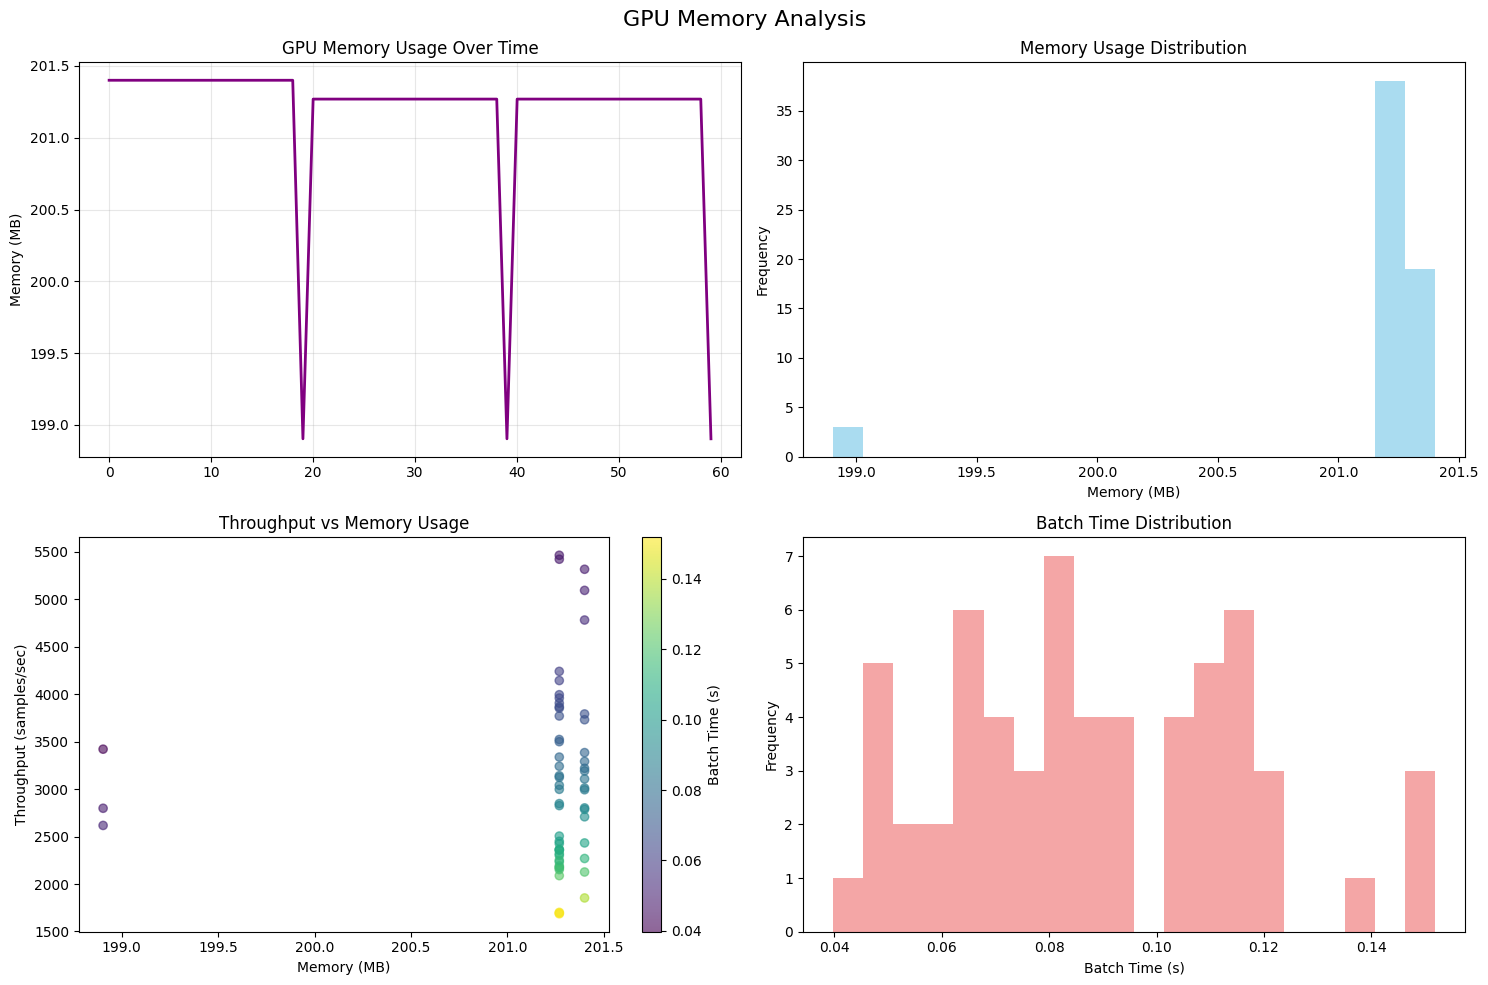


📊 PERFORMANCE SUMMARY
Average Throughput (samples/sec)   : 3072.8
Peak GPU Memory (MB)               : 201.4
Average GPU Memory (MB)            : 201.2
Average Batch Time (ms)            : 88.5
Memory Efficiency (%)              : 99.9
Total Samples Processed            : 15360
💾 Saving results...
✅ Results saved to: /content/profiling_results

📥 Download your results:
   - Profiling Results: /content/profiling_results/profiling_results.json
   - Dashboard: /content/profiling_results/colab_dashboard.html
   - Memory Analysis: /content/profiling_results/memory_analysis.png

✅ Profiling completed successfully!


In [ ]:
profiler = run_quick_profile()

In [1]:

import shutil
shutil.make_archive('/content/gpu_profiler_project', 'zip', '/content')



'/content/gpu_profiler_project.zip'